# Data Exploration & Research

## Default imports

In [1]:
import os
import sys
import cv2
import json
import numpy as np
import pandas as pd
import scipy
import scipy.io
import sklearn
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm
import glob
import seaborn as sns

%matplotlib inline

## Video Image Split

In [2]:
!ls ./poc_dataset/images

VIRAT_S_000002_fr_0.2  VIRAT_S_000002_fr_2.0


In [3]:
def filter_file_extension(filename):
    
    file_extension = 'mp4'
    
    if file_extension in filename:
        return True
    else:
        return False

def get_videos_from_folder(path):
    
    all_items = os.listdir(path)
    only_videos = [video_name for video_name in filter(filter_file_extension, all_items)]
    video_filenames = [video_name.split('.')[0] for video_name in only_videos]
    videos_file_paths = [os.path.join(path, video_fp) for video_fp in only_videos]
    
    return videos_file_paths, video_filenames

In [57]:
video_file_paths, video_filenames = get_videos_from_folder('./poc_dataset/')

In [4]:
def get_frame(sec, video_object):
    '''
        Based on the given sec, extract the resulting image from the video_object.
    '''
    video_object.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
    success, image = video_object.read()
    return success, image
    

def write_images_from_video(video_path, video_filename, frame_rate):
    '''
        Splits the video by the frame_rate, shown in the video_path variable into different frames,
        then writes the resulting images in a folder with the  video's filename.
        Creates the folder if it exits.
    
    '''
    video_object = cv2.VideoCapture(video_path)
    sec = 0
    count = 0
    frame_rate = 1 / frame_rate # looking at the actual time from second to the next
    success = 1
    
    while success:
        
        success, image = get_frame(sec, video_object)
        
        # create the folder if not exists
        video_file_name = f'{video_filename}_fr_{frame_rate}'
        folder_path = f'./poc_dataset/images/{video_file_name}'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        # write the image
        cv2.imwrite(os.path.join(folder_path, f'{video_filename}_frame_{np.round(count,2)}.jpg'), image)
        
        sec = sec + frame_rate
        count += 1
    
    print(f'File {video_filename} processed.')

In [59]:
write_images_from_video(video_file_paths[0], video_filenames[0], 0.5)

File VIRAT_S_000002 processed.


## Display a sample image

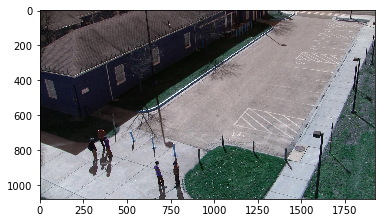

In [7]:
# choose a random image
folder = './poc_dataset/images/VIRAT_S_000002_fr_2.0/'
dirlist = np.array(os.listdir(folder))
choice = np.random.choice(dirlist)
image_path = os.path.join(folder, choice)

show_image(image_path)

We can see a number of people captured in a webcam from an angle, which is the expectation.

## Utils
Various helper functions that are used in general. It will be used throughout the notebook

In [5]:
def load_csv_datasets(path):
    files = os.listdir(path)
    
    data = {}
    for file in files:
        filename = file.split('.')[0]
        filepath = os.path.join(path, file)
        data[filename] = pd.read_csv(filepath)
    
    return data

In [12]:
def show_image(path):
    image = cv2.imread(path)
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.imshow(image)

## Image Perspective Experimentation.
The goal is to change the perspective so we can get a top down perspective. That way a layout could be superimposed on the image and identify the areas, in which people are gathered.

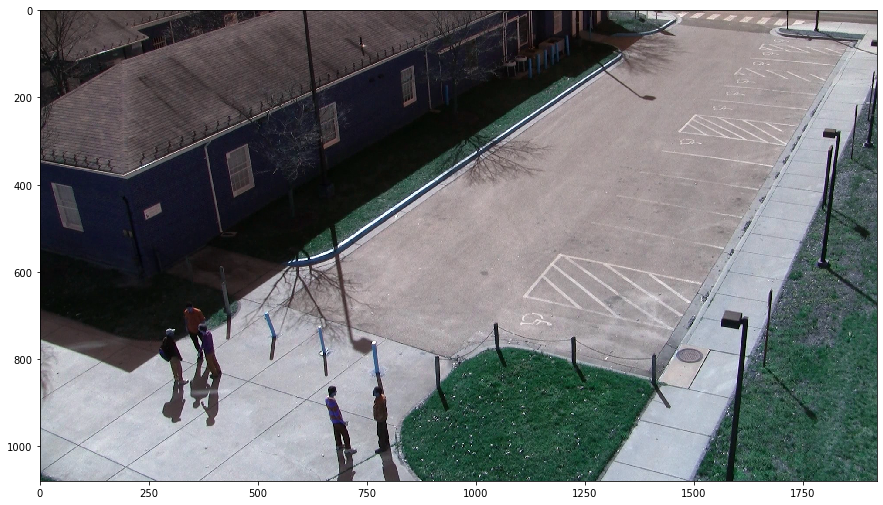

In [13]:
show_image(image_path)

### 1. Setting the perspective points

In [158]:
point1, point2, point3, point4 = (240, 880), (800, 1060), (1160, 230), (1480, 260)
points = [point1, point2, point3, point4]

In [159]:
img = cv2.imread(image_path)
for point in points:
    cv2.circle(img, point, 10, (255, 0, 0), -1)

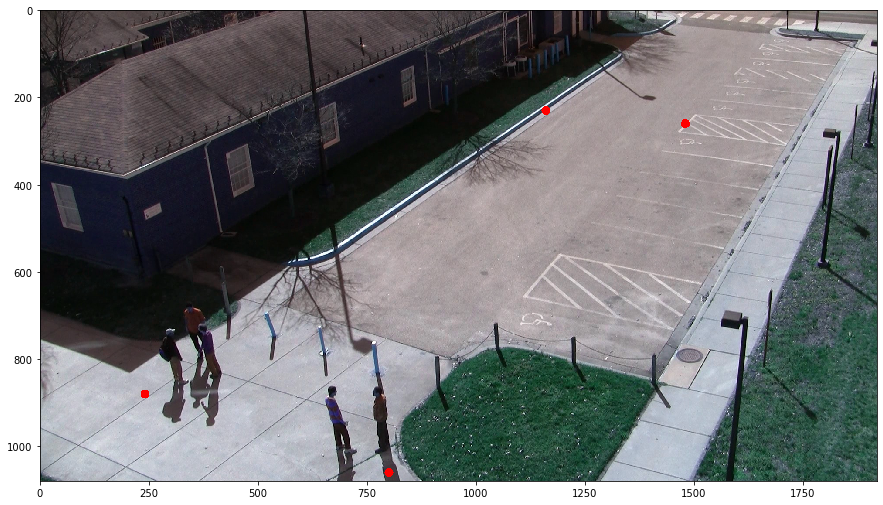

In [160]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.imshow(img)

### 2. Warping the perespective

In [98]:
pts1 = np.float32([[point1[0], point1[1]],[point2[0], point2[1]],[point3[0], point3[1]],[point4[0], point4[1]]])
pts2 = np.float32([[0,0],[600,0],[0,600],[600,600]])

In [99]:
transform = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img, transform, (600,600))

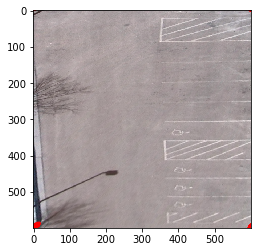

In [100]:
plt.imshow(dst)

## Training Datasets Exploration

### 0. Dataset Exploration Utils
Various Utilities that will aid in the creation of a dataset

In [3]:
def create_summary_df(images_paths, dataset_subset):
    df_dict = {'image_name':[], 'df_subset': [], 'w':[],'h':[] }
    for img_path in tqdm(images_paths):
        img = plt.imread(img_path)
        img_name = img_path.split('/')[-1].split('.jpg')[0]
        df_dict['image_name'].append(img_name)
        df_dict['df_subset'].append(dataset_subset)
        df_dict['w'].append(img.shape[1])
        df_dict['h'].append(img.shape[0])
    
    return pd.DataFrame(df_dict)

In [4]:
def get_total_summary_df(train_path, test_path):
    train_img_paths = glob.glob(os.path.join(train_path, '*.jpg'))
    test_img_paths = glob.glob(os.path.join(test_path, '*.jpg'))
    train_summary_df = create_summary_df(train_img_paths, 'train')
    test_summary_df = create_summary_df(test_img_paths, 'test')
    
    return pd.concat([train_summary_df, test_summary_df]), train_summary_df, test_summary_df

### 1. UCF-QNRF_ECCV18

#### 1.1. Single Image Example

In [22]:
ucf_qnrf_example = scipy.io.loadmat('training_dataset/UCF-QNRF_ECCV18/Train/img_0001_ann.mat')
print(ucf_qnrf_example.keys())
print(ucf_qnrf_example['annPoints'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'annPoints'])
(433, 2)


In [26]:
ucf_qnrf_example['annPoints'][0]

array([ 111.50251889, 1560.9534005 ])

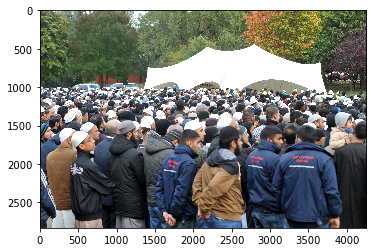

In [3]:
img = plt.imread('training_dataset/UCF-QNRF_ECCV18/Train/img_0001.jpg')
plt.imshow(img)

In [4]:
img.shape

(2832, 4256, 3)

The UCF-QNRF seems to have one jpg of size 4256x2832 with a companion .mat file that contains all the annotation points. What I am curious about is if all the images, contained in the dataset are of the same size.

#### 1.2 Creating a summary df

In [23]:
ucf_train_path = 'training_dataset/UCF-QNRF_ECCV18/Train/'
ucf_test_path = 'training_dataset/UCF-QNRF_ECCV18/Test/'

In [24]:
ucf_df_summary, ucf_df_train, ucf_df_test = get_total_summary_df(ucf_train_path, ucf_test_path)

 99%|█████████▉| 332/334 [00:42<00:00,  8.77it/s]/home/fury/anaconda3/envs/opencv/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125214 bytes but only got 64515. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
100%|██████████| 334/334 [00:43<00:00,  7.76it/s]


#### 1.3 Exploring Image Size

In [25]:
print('Mean image width: ', ucf_df_summary['w'].mean())
print('Mean image height: ', ucf_df_summary['h'].mean())

Mean image width:  2901.51335504886
Mean image height:  2011.2527687296417


In [26]:
ucf_df_summary.describe()

,w,h
count,1535.000000,1535.000000
mean,2901.513355,2011.252769
std,1503.141778,1077.346852
min,300.000000,163.000000
25%,1600.000000,1066.000000
50%,2990.000000,2048.000000
75%,4002.000000,2848.000000
max,7360.000000,9999.000000


So the average size of the image is 2901 by 2011, with values for width ranging from 300 to 7360, while the hheight goes from 163 to 9999(wow...).

#### 1.4 Exploring Aspect Ratio

In [29]:
ucf_df_summary['aspect_ratio'] = ucf_df_summary['w'] / ucf_df_summary['h']

In [30]:
avg_aspect_ratio = ucf_df_summary['aspect_ratio'].mean()
median_aspect_ratio = ucf_df_summary['aspect_ratio'].median()
min_aspect_ratio = ucf_df_summary['aspect_ratio'].min()
max_aspect_ratio = ucf_df_summary['aspect_ratio'].max()

In [31]:
avg_aspect_ratio, median_aspect_ratio, min_aspect_ratio, max_aspect_ratio

(1.4783253722573935, 1.5, 0.5878360032582134, 4.101167315175097)

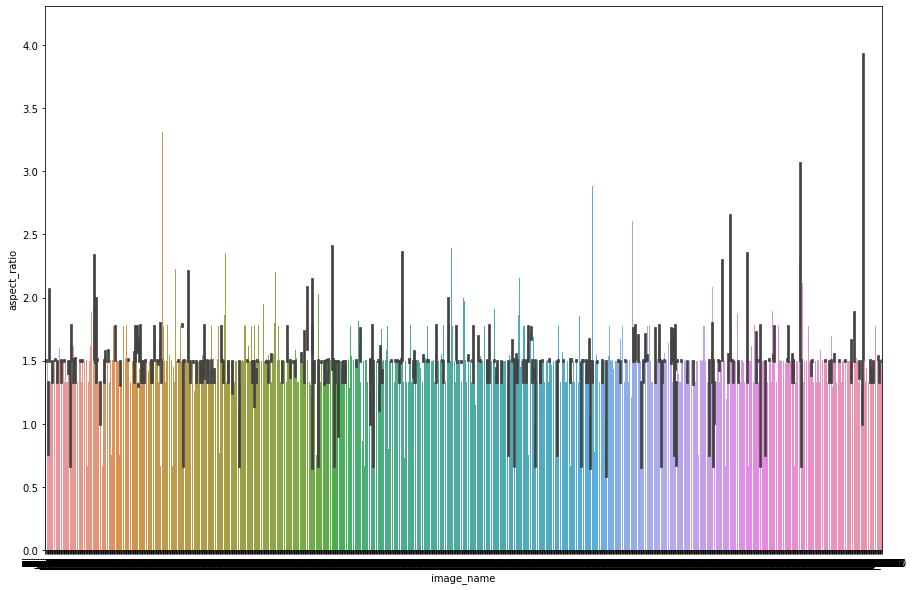

In [32]:
# plot it
plt.subplots(figsize=(15, 10))
ax = sns.barplot(x='image_name', y='aspect_ratio', data=ucf_df_summary)
plt.show()

Although they are a couple of outliers its seems that predominantely the aspect ratio is 1.5.

#### 1.5 Splitting the training data to different smaller datasets
Since the annotations points require a density map to be generated and since the process is single-threaded it takes roughly 12 minutes to perform 1 image on my PC. I see this as a good learning opportunity. I will split the training dataset into 3 smaller datasets to be processes independently. The split will be 50/25/25.

In [56]:
first_split = int(len(train_img_paths)/2)
second_split = int((len(train_img_paths) - first_split)/2)

In [80]:
train_mat_paths = glob.glob(os.path.join(train_path, '*.mat'))
dataset_index_dict = {'path':train_mat_paths}
training_df_list = pd.DataFrame(dataset_index_dict)
training_df_list['df_split_id'] = 0
training_df_list.loc[first_split:(first_split + second_split), 'df_split_id'] = 1
training_df_list.loc[(first_split + second_split):, 'df_split_id'] = 2

In [81]:
# write all datasets to csvs
for i in range(0, 3):
    training_df_list[training_df_list['df_split_id'] == i].to_csv(f'training_dataset/split_{i}.csv')

##### -- Dealing with the tests set as well.

In [8]:
test_summary.head()

,image_name,df_subset,w,h
0,img_0122,test,1800,1205
1,img_0328,test,458,600
2,img_0263,test,1200,800
3,img_0321,test,1024,768
4,img_0080,test,1200,900


In [9]:
test_summary.shape

(334, 4)

In [11]:
test_mat_paths = glob.glob(os.path.join(test_path, '*.mat'))
ds_test_index_dict = {'path':test_mat_paths}
testing_df_list = pd.DataFrame(ds_test_index_dict)
testing_df_list['df_split_id'] = 0
testing_df_list.to_csv('training_dataset/test_split.csv')

#### 1.6 The Density Map Generation Process

I'm going to detail the density map generation process.
Since a lot of these images have a huge (by my understanding) image size we need a similarly 'huge' density map. That is why I have decided to create a small batching procedure to be able to process as much as I need in one go and save all of the data in a singular .h5 file. Below is the code needed to do that.

In [18]:
def gaussian_filter_density(gt):
    '''
        Filters the input ground truth.
    '''
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')

    return density

def gen_gt(img, points):
    '''
        Generates a ground truth density map by first filing the image shape
        and then applying gaussian filtering.
    '''
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = points
    for i in range(0, len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])] = 1
    k = gaussian_filter_density(k)

    return k


def handle_image(imgpath):
    im = Image.open(imgpath)
    return np.array(im)

def handle_mat_file(matpath, imgpath, write_loc):
    '''
        Takes the location of the math file and creates a sample h5 file.
    '''
    mat_loaded = scipy.io.loadmat(matpath)
    ann_points = mat_loaded['image_info'][0][0][0][0][0]
    
    image_filepath = matpath.split('_a')[0]
    image_name = image_filepath.split('/')[-1]
    
    image_array = handle_image(imgpath)
    
    density = gen_gt(image_array, ann_points)
    count = mat_loaded['image_info'][0][0][0][0][0].shape[0]
    
    # write to disk
    hf = h5py.File(f'{write_loc + image_name}.h5', 'w')
    hf.create_dataset('image_name', data=image_name)
    hf.create_dataset('image_array', data=image_array)
    hf.create_dataset('density_map', data=density)
    hf.create_dataset('count', data=count)
    hf.close()

In [6]:
def process_batch(batch, num_procs=4):
    '''
        Gets the density/count vector by reading the .mat file 
        and getting the shape of the file. 
        The function only requires the path to the dataset.
    '''
    # get only the split_0 csv
    write_location = 'training_dataset/UCF-QNRF_ECCV18/Train/'

    
    only_mat_files = list(batch['path'].values)
    
    jobs = []
    for i in range(0, num_procs):
        mat = only_mat_files[i]
        process = multiprocessing.Process(target=handle_mat_file,
                                         args=(mat, write_location, i))
        
        jobs.append(process)
    
    for j in jobs:
        j.start()
    
    for j in jobs:
        j.join()
        
    # batched n:n + num_procs proccessed
    items_processed = list(batch['id'])
    return items_processed

In addition to the processing of the images on the local machine I will make a simple airflow pipeline that uses some workers to perform the same task on split_1.csv.

Example of the pipeline below:  
![airflow_pipeline](img/af_pipeline.png)

The idea is simple - split the dataset in 3 ways and each worker will process a third of it (as I have only 3 workers assigned to airflow).

#### 1.7 Sinngle file export
The goal here would be to export a single file that is going to be used for densemap generation.

In [33]:
ucfq_train_mat_paths = sorted(glob.glob(os.path.join(ucf_train_path, '*.mat')))
ucfq_train_img_paths = sorted(glob.glob(os.path.join(ucf_train_path, '*.jpg')))
ucfq_dataset_index_dict = {'mat_path':ucfq_train_mat_paths, 'img_path': ucfq_train_img_paths}
ucfq_training_df_list = pd.DataFrame(ucfq_dataset_index_dict)
ucfq_training_df_list['df_split_id'] = 0

In [36]:
ucfq_training_df_list.to_csv('training_dataset/ucf_qnrf_train.csv')

In [37]:
ucfq_test_mat_paths = sorted(glob.glob(os.path.join(ucf_test_path, '*.mat')))
ucfq_test_img_paths = sorted(glob.glob(os.path.join(ucf_test_path, '*.jpg')))
ucfq_test_dataset_index_dict = {'mat_path':ucfq_test_mat_paths, 'img_path': ucfq_test_img_paths}
ucfq_test_df_list = pd.DataFrame(ucfq_test_dataset_index_dict)
ucfq_test_df_list['df_split_id'] = 0

In [38]:
ucfq_test_df_list.to_csv('training_dataset/ucf_qnrf_test.csv')

### 2. Shanghai_Tech Part A

#### 2.1 Single Image Example

In [13]:
shanghaiA_example = scipy.io.loadmat('training_dataset/ShanghaiTech/part_A/train_data/ground-truth/GT_IMG_1.mat')
print(shanghaiA_example.keys())
print(shanghaiA_example['image_info'][0][0][0][0][0].shape)

dict_keys(['__header__', '__version__', '__globals__', 'image_info'])
(1546, 2)


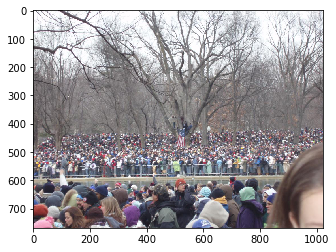

In [14]:
img = plt.imread('training_dataset/ShanghaiTech/part_A/train_data/images/IMG_1.jpg')
plt.imshow(img)

#### 2.2 Creating a summary DF
Reusing the code for the previous dataset.

In [2]:
train_path_sgha = 'training_dataset/ShanghaiTech/part_A/train_data/images/'
test_path_sgha = 'training_dataset/ShanghaiTech/part_A/test_data/images/'

In [6]:
sgha_summary_df, sgha_train_summary_df, sgha_test_summary_df = get_total_summary_df(train_path_sgha, test_path_sgha)

100%|██████████| 182/182 [00:01<00:00, 113.53it/s]


#### 2.3 Exploring image sizes

In [9]:
print('Mean image width: ', sgha_summary_df['w'].mean())
print('Mean image height: ', sgha_summary_df['h'].mean())

Mean image width:  868.311203319502
Mean image height:  589.2800829875519


#### 2.4 Exploring Aspect Ratio

In [10]:
sgha_summary_df['aspect_ratio'] = sgha_summary_df['w'] / sgha_summary_df['h']
avg_aspect_ratio = sgha_summary_df['aspect_ratio'].mean()
median_aspect_ratio = sgha_summary_df['aspect_ratio'].median()
min_aspect_ratio = sgha_summary_df['aspect_ratio'].min()
max_aspect_ratio = sgha_summary_df['aspect_ratio'].max()

In [11]:
avg_aspect_ratio, median_aspect_ratio, min_aspect_ratio, max_aspect_ratio

(1.521197278046642, 1.499267935578331, 0.6546644844517185, 3.427007299270073)

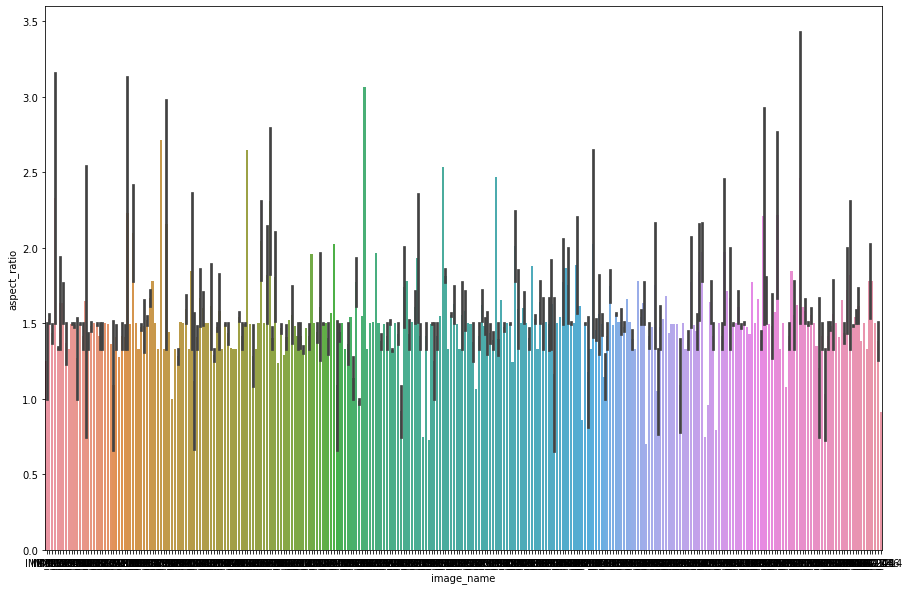

In [12]:
# plot it
plt.subplots(figsize=(15, 10))
ax = sns.barplot(x='image_name', y='aspect_ratio', data=sgha_summary_df)
plt.show()

The same as UCF-QNRF dataset - the median aspect ratio is at 1.5.

#### 2.5 Creating a split list
Creating a list that will contain the list of the images - afterwards the whole thing will be sent of to airflow for desnity map generation. 

In [7]:
sgha_train_path_mat = 'training_dataset/ShanghaiTech/part_A/train_data/ground-truth/'
sgha_train_mat_paths = sorted(glob.glob(os.path.join(sgha_train_path_mat, '*.mat')))
sgha_train_img_paths = sorted(glob.glob(os.path.join(train_path_sgha, '*.jpg')))
sgha_dataset_index_dict = {'mat_path':sgha_train_mat_paths, 'img_path': sgha_train_img_paths}
sgha_training_df_list = pd.DataFrame(sgha_dataset_index_dict)
sgha_training_df_list['df_split_id'] = 0

In [8]:
sgha_testing_path_mat = 'training_dataset/ShanghaiTech/part_A/test_data/ground-truth/'
sgha_testing_mat_paths = sorted(glob.glob(os.path.join(sgha_testing_path_mat, '*.mat')))
sgha_testing_img_paths = sorted(glob.glob(os.path.join(test_path_sgha, '*.jpg')))
sgha_dataset_tst_index_dict = {'mat_path':sgha_testing_mat_paths, 'img_path': sgha_testing_img_paths}
sgha_testing_df_list = pd.DataFrame(sgha_dataset_tst_index_dict)
sgha_testing_df_list['df_split_id'] = 0

In [9]:
sgha_testing_df_list.loc[0, 'img_path']

'training_dataset/ShanghaiTech/part_A/test_data/images/IMG_1.jpg'

In [10]:
sgha_testing_df_list.loc[0, 'mat_path']

'training_dataset/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat'

In [56]:
sgha_testing_df_list.to_csv('training_dataset/sgha_test_split.csv')

In [32]:
tst = pd.read_csv('training_dataset/sgha_split.csv')

In [43]:
tst.loc[0, 'mat_path'].split('part_A')[1][1:]

'train_data/ground-truth/GT_IMG_1.mat'

### 3. Shanghai_Tech Part B

#### 3.1 Single Image Example

In [5]:
shanghaiA_example = scipy.io.loadmat('training_dataset/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_1.mat')
print(shanghaiA_example.keys())
print(shanghaiA_example['image_info'][0][0][0][0][0].shape)

dict_keys(['__header__', '__version__', '__globals__', 'image_info'])
(233, 2)


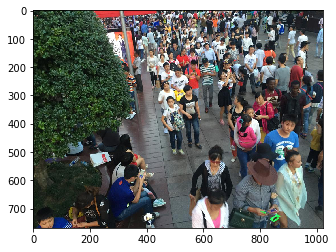

In [8]:
img = plt.imread('training_dataset/ShanghaiTech/part_B/train_data/images/IMG_1.jpg')
plt.imshow(img)

#### 3.2 Create a summary DF

In [11]:
train_path_sghb = 'training_dataset/ShanghaiTech/part_B/train_data/images/'
test_path_sghb = 'training_dataset/ShanghaiTech/part_B/test_data/images/'

In [12]:
sghb_summary_df, sghb_train_summary_df, sghb_test_summary_df = get_total_summary_df(train_path_sghb, test_path_sghb)

100%|██████████| 316/316 [00:03<00:00, 83.21it/s]


#### 3.3 Exploring image sizes

In [11]:
print('Mean image width: ', sghb_summary_df['w'].mean())
print('Mean image height: ', sghb_summary_df['h'].mean())

Mean image width:  1024.0
Mean image height:  768.0


#### 3.4 Exploring aspect ratio

In [12]:
sghb_summary_df['aspect_ratio'] = sghb_summary_df['w'] / sghb_summary_df['h']
avg_aspect_ratio = sghb_summary_df['aspect_ratio'].mean()
median_aspect_ratio = sghb_summary_df['aspect_ratio'].median()
min_aspect_ratio = sghb_summary_df['aspect_ratio'].min()
max_aspect_ratio = sghb_summary_df['aspect_ratio'].max()

In [13]:
avg_aspect_ratio, median_aspect_ratio, min_aspect_ratio, max_aspect_ratio

(1.3333333333333335,
 1.3333333333333333,
 1.3333333333333333,
 1.3333333333333333)

Data is consitent, no use for a plot - the images are 1024x768.

#### 3.5 Creating a split list

In [13]:
sghb_train_path_mat = 'training_dataset/ShanghaiTech/part_B/train_data/ground-truth/'
sghb_train_mat_paths = sorted(glob.glob(os.path.join(sghb_train_path_mat, '*.mat')))
sghb_train_img_paths = sorted(glob.glob(os.path.join(train_path_sghb, '*.jpg')))
sghb_dataset_index_dict = {'mat_path':sghb_train_mat_paths, 'img_path': sghb_train_img_paths}
sghb_training_df_list = pd.DataFrame(sghb_dataset_index_dict)
sghb_training_df_list['df_split_id'] = 0

In [14]:
sghb_testing_path_mat = 'training_dataset/ShanghaiTech/part_B/test_data/ground-truth/'
sghb_testing_mat_paths = sorted(glob.glob(os.path.join(sghb_testing_path_mat, '*.mat')))
sghb_testing_img_paths = sorted(glob.glob(os.path.join(test_path_sghb, '*.jpg')))
sghb_dataset_tst_index_dict = {'mat_path':sghb_testing_mat_paths, 'img_path': sghb_testing_img_paths}
sghb_testing_df_list = pd.DataFrame(sghb_dataset_tst_index_dict)
sghb_testing_df_list['df_split_id'] = 0

In [17]:
sghb_training_df_list.to_csv('training_dataset/sghb_train_split.csv')
sghb_testing_df_list.to_csv('training_dataset/sghb_test_split.csv')

### 4. Creating a joint Shanghai dataset
Assuming all of the above cells for the shanghai datasets have been run I will create a joint dataset to be processed.

In [20]:
sgh_train_df = pd.concat([sgha_training_df_list, sghb_training_df_list])
sgh_test_df = pd.concat([sgha_testing_df_list, sghb_testing_df_list])

In [21]:
sgh_train_df.to_csv('training_dataset/sgh_train_common.csv')
sgh_test_df.to_csv('training_dataset/sgh_test_common.csv')

In [26]:
df = pd.read_csv('training_dataset/sgh_train_common.csv')
df.columns = ['id', 'mat_path', 'img_path', 'df_split_id']
df['mat_path'] = df['mat_path'].apply(lambda x: x.split('ShanghaiTech')[1][1:])
df['img_path'] = df['img_path'].apply(lambda x: x.split('ShanghaiTech')[1][1:])

In [27]:
df

,id,mat_path,img_path,df_split_id
0,0,part_A/train_data/ground-truth/GT_IMG_1.mat,part_A/train_data/images/IMG_1.jpg,0
1,1,part_A/train_data/ground-truth/GT_IMG_10.mat,part_A/train_data/images/IMG_10.jpg,0
2,2,part_A/train_data/ground-truth/GT_IMG_100.mat,part_A/train_data/images/IMG_100.jpg,0
3,3,part_A/train_data/ground-truth/GT_IMG_101.mat,part_A/train_data/images/IMG_101.jpg,0
4,4,part_A/train_data/ground-truth/GT_IMG_102.mat,part_A/train_data/images/IMG_102.jpg,0
...,...,...,...,...
695,395,part_B/train_data/ground-truth/GT_IMG_95.mat,part_B/train_data/images/IMG_95.jpg,0
696,396,part_B/train_data/ground-truth/GT_IMG_96.mat,part_B/train_data/images/IMG_96.jpg,0
697,397,part_B/train_data/ground-truth/GT_IMG_97.mat,part_B/train_data/images/IMG_97.jpg,0
698,398,part_B/train_data/ground-truth/GT_IMG_98.mat,part_B/train_data/images/IMG_98.jpg,0


### 5. The FDST Dataset

#### 5.1 Single Image Example

In [3]:
img_map = json.load(open('training_dataset/fdst/train_data/1/001.json'))

In [18]:
list(img_map.keys())[0]

'001.jpg145624'

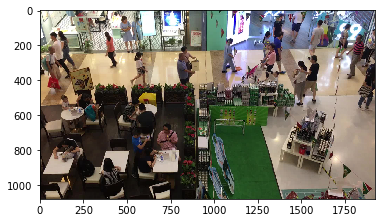

In [7]:
img = plt.imread('training_dataset/fdst/train_data/1/001.jpg')
plt.imshow(img)

#### 5.2 Create a summary DF

In [7]:
# define the dataset path
fdst_path_train = 'training_dataset/fdst/train_data/'
fdst_path_test = 'training_dataset/fdst/test_data/'

In [8]:
def get_jpg_json_pairs(file_path):
    subfolder_list = os.listdir(file_path)
    full_folder_list = [os.path.join(file_path, folder) for folder in subfolder_list]
    full_image_list = [sorted(glob.glob(os.path.join(folder, '*.jpg'))) for folder in full_folder_list]
    full_map_list = [sorted(glob.glob(os.path.join(folder, '*.json'))) for folder in full_folder_list]
    full_image_list = [item for sublist in full_image_list for item in sublist]
    full_map_list = [item for sublist in full_map_list for item in sublist]
    return full_image_list, full_map_list

In [9]:
train_full_image_list, train_full_map_list = get_jpg_json_pairs(fdst_path_train)
test_full_image_list, test_full_map_list = get_jpg_json_pairs(fdst_path_test)

In [31]:
def create_summary_df(images_paths, dataset_subset):
    df_dict = {'image_name':[], 'df_subset': [], 'w':[],'h':[] }
    for img_path in tqdm(images_paths):
        img = plt.imread(img_path)
        img_name = img_path.split('/')[-1].split('.jpg')[0]
        df_dict['image_name'].append(img_name)
        df_dict['df_subset'].append(dataset_subset)
        df_dict['w'].append(img.shape[1])
        df_dict['h'].append(img.shape[0])
    
    return pd.DataFrame(df_dict)

In [32]:
train_fdst_summary_df = create_summary_df(train_full_image_list, 'train')
test_fdst_summary_df = create_summary_df(test_full_image_list, 'test')

100%|██████████| 6000/6000 [02:11<00:00, 45.50it/s]


In [34]:
print('Mean image width: ', train_fdst_summary_df['w'].mean())
print('Mean image height: ', train_fdst_summary_df['h'].mean())

Mean image width:  1856.0213262245918
Mean image height:  1044.0119960013328


There are some images that are not 1920x1080, but the mean is close to it.

#### 5.3 Creating a split list

In [33]:
len(train_full_image_list), len(train_full_map_list)

(9003, 9003)

In [36]:
len(test_full_image_list), len(test_full_map_list)

(6000, 6000)

In [27]:
train_fdst_index_dict = {'mat_path':train_full_map_list, 'img_path': train_full_image_list}
train_fdst_training_df = pd.DataFrame(train_fdst_index_dict)
train_fdst_training_df['df_split_id'] = 0

In [28]:
test_fdst_index_dict = {'mat_path':test_full_map_list, 'img_path': test_full_image_list}
test_fdst_training_df = pd.DataFrame(test_fdst_index_dict)
test_fdst_training_df['df_split_id'] = 0

In [29]:
train_fdst_training_df.to_csv('training_dataset/fdst_train_split.csv')
test_fdst_training_df.to_csv('training_dataset/fdst_test_split.csv')

## Research

### 1. People Counting with Object Detection Methods

[Reference](https://machinelearningmastery.com/object-recognition-with-deep-learning/?fbclid=IwAR3QHzwV3iteB2tE7EJo3GkNTT_v7loLqHtCqYuH5nopySIkzvTmHiUa-H0)

#### 1.1 Faster R-CNN
* [Reference of Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf)  
* [Reference of implementation](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)
* [Reference Jupyter Notebook for the implementation](https://github.com/RockyXu66/Faster_RCNN_for_Open_Images_Dataset_Keras/blob/master/frcnn_train_vgg.ipynb)

#### 1.1.1 Implemented Faster RCNN
Faster RCNN is the third itteration of the RCNN implementation, with the advantage of being faster. This is due to implementing a RPN (region proposal network) instead of using SS (selective search). More details can be found in the following papers:
* [Rich feature hierarchies for accurate object detection and semantic segmentation](https://arxiv.org/abs/1311.2524)
* [Fast R-CNN](https://arxiv.org/abs/1504.08083)
* [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497)

### 1.2. YOLO
The YOLO (You Only Look Once) Algorithm for Object Detection. You can find more details by reading the paper:
* [YOLOv3: An Incremental Improvement](https://pjreddie.com/media/files/papers/YOLOv3.pdf).  
For the purpose of the PoC a pretrained model will be used, or more specificaly [keras-yolo3](https://github.com/experiencor/keras-yolo3). 

## 2. Problems with scaling the solution
The problem is with the previous methods is that when scaling the solution for crowds (or large quantities of people in the picture) occlusion and clutter will play a large role and the model will not be able to make an accurate prediction. Thus an [alternative approach](https://arxiv.org/pdf/1906.09707.pdf) will be used by using density maps.